# Problem Statement

I'm trying to write a <b>real-time</b> (>= 30 FPS), specialized OCR solution to gather player damage and match timer samples from the <i>Super Smash Brothers: Ultimate</i> (SSBU) in-game HUD. The image below identifies the text of interest with green rectangles.

<img src="images/regions.png" />

The goal is to surface real-time time-series damage data and statistics to Twitch stream viewers while the match unfolds. We've already implemented such an end-to-end solution for one of SSBU's predecessors, the web front-end for which lives at <a href="https://metascouter.gg">metascouter.gg</a>.

The preexisting solution is for <i>Super Smash Brothers: Melee</i> (SSBM). For SSBM I used some heuristics and simple thresholding to segment individual digits. Each segment then undergoes some normalization before being scored with template matching against exemplar characters for digits 0-9. The SSBU timer displayed in the upper-right corner of the screen is consistently white-on-gray, so I believe I can re-use my SSBM-purposed implementation in that instance. However, Ultimate's player damage is newer and flashier. SSBU decorates its digits with more movement, a variety of colors and on occasion, the digits partially occlude one another. I've included some examples of this in the following images.

<table border=0>
    <tr>
        <td><img src="images/movement_1.png" /></td>
        <td><img src="images/movement_and_occlusion_1.png" /></td>
        <td><img src="images/occlusion_1.png" /></td>
    </tr>
</table>

## Timeline and requirements

I'm to implement a production-ready solution for a major tournament on February 2nd of 2019, and I'd ideally like some breathing room ahead of that date. So, I'm looking to get something working quickly. 

To simplify things under a short timeframe, text localization can be done by manually selecting regions of interest at match-time. However, I am interested in developing a very fast digit/text region localization solution in the long term.  

It's worth noting that our SSBM solution filters digit sequence values over a 12-frame window at 30FPS. This would allow for some temporal consensus and a voting scheme compensates for bad readings. We'll be able to do the same here, so the per-frame accuracy requirements don't need to be stellar. 90% classification accuracy *over digit sequences* in all reasonable cases is my currently-stated goal.

# Approaches to the problem

I need some expert help in evaluating the sanity of some of these possible solutions and quickly turning around experiments to inform product-ready implementation decisions. I'm looking at two high-level approaches at the moment:


## 1) Pixel classifier for digit segmentation + character classification

### Pixel classification
A solution which reliably segments digits for running through a digit classifier would be great. I'm currently primarily examining this route since it's similar to what I've done for SSBM, and we still have a fixed "font" of digit exemplar images to work against.

However, as I mentioned earlier the variation in color makes segmentation more difficult than it was in SSBM and I haven't yet landed on an acceptable solution to identify relevant pixels.

I've done some analysis on the volume of "in-digit" pixel values in HSV color space, and there is definitely some structure (see below). However I'm not certain of the best way to go about modeling that structure. 

<img src="images/hsv.png" />

Below this introduction you'll find some experimentation and results using a Gaussian Naive Bayes classifier to identify "in-digit" pixels using HSV color value components as features. It's of course insufficient given that the target volume pictured above can't be characterized by a single Gaussian distribution. It's worth noting though that the classifier performs pretty well in a particular modality where pixel values are clustered around yellow/orange. At a glance that seems to correspond to the center-of-mass of the plotted volume so I'm optimistic about applying some kind of clustering and/or mixture model. I've also thought about using decision trees to facilitate a highly parallel approach to this problem, similar to <a href="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/BodyPartRecognition.pdf">the approach the Kinect team took for human body-part classification</a>. In addition to considering colors, the features considered in a decision tree-based solution could include some spatial information, or neighbor pixel colors as well.

### Character classification
Template matching worked in SSBM, but it was comparatively simple to get very clean segments from relevant digits. It's not yet clear to me that this will be possible in SSBU. Template matching is very sensitive to any kind of morphological deviation from the template image, so I'll likely need a more robust digit classifier.

In the past I've tried dividing digits up into sub-regions and extracting features from those sub-regions to feed to an SVM. Template matching still performed better though, so I tossed that aside. 

Additional suggestions for digit classification as it applies to this problem are very welcome.

## 2) Deep learning

While data collection, training and model tuning can be difficult and complex, the end result of using a CNN-based solution could possibly simplify our implementations considerably. A one-shot network which produces digit sequences in real-time might be overkill for this problem, but it also has the chance to be very robust and simple to deploy in production.

I've looked over <a href="https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf">this paper</a> several times, which details Google's approach to digit sequence classification for building numbers discovered in Google Street View photos. They effectively solve this problem for Google's internal, much larger analog of SVHN using a CNN with 8 convolutional layers and two fully connected layers. I'd like to think that, given the improvements in CNN architectures since 2013 and the much more constrained problem space for digit classification in SSBU, that we could achieve adequate performance with a model shallow enough to produce real-time results.

However, I've never built a CNN model on my own and would feel more comfortable getting an expert's take on this assertion before traveling down that road.

In [27]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import cv2

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

In [26]:
hdf_path = r'E:/ultimate/day1_streams/masks/df.hdf'

df = pd.read_hdf(hdf_path)
df.head()

hue  inmask  saturation     value
0  0.454902   False    0.192157  0.407843
1  0.454902   False    0.203922  0.384314
2  0.447059   False    0.192157  0.388235
3  0.447059   False    0.184314  0.403922
4  0.447059   False    0.168627  0.443137

In [3]:
df['inmask_clean'] = np.where(df['inmask'] == True, 1.0, 0.0)
x_train, x_test = train_test_split(df, test_size=0.6, random_state=int(time.time()))

gnb = GaussianNB()
used_features = [
    'hue',
    'value',
    'saturation'
]

gnb.fit(
    x_train[used_features].values,
    x_train['inmask_clean']
)

y_pred = gnb.predict(x_test[used_features])

In [4]:
points = (x_test['inmask_clean'] != y_pred).sum()
print('Number of mislabeled points out of a total {} points: {}'.format(
    x_test.shape[0],
    points
))

Number of mislabeled points out of a total 3235592 points: 95676


In [5]:
print('Performance = {:05.2f}%'.format(100 * (1.0 - float(points) / x_test.shape[0])))

Performance = 97.04%


Huh. That doesn't seem right...

In [6]:
#
# Just messing around with model persistence...
#
with open(model_path, 'wb') as fw:
    pickle.dump(gnb, fw)

In [7]:
with open(model_path, 'rb') as fr:
    gnb = pickle.load(fr)

In [17]:
def test_and_plot_image(imgpath):
    im = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
    im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    flat_hsv = im_hsv.reshape(-1, 3)
    
    hues = []
    values = []
    saturations = []
    inmask = []
    
    img_hues, img_values, img_saturations = np.hsplit(flat_hsv / 255.0, 3)
    temp_df = pd.DataFrame({
        'hue'         : [float(v) for v in img_hues],
        'value'       : [float(v) for v in img_values],
        'saturation'  : [float(v) for v in img_saturations]        
    })
    
    pred_mask = gnb.predict(temp_df)
    pred_img = pred_mask.reshape(im_hsv.shape[0], im_hsv.shape[1])
    
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(im)
    ax[1].imshow(pred_img)

In [20]:
test_image_path = 'E:/Ultimate/day1_streams/masks/102_58.1.png'
image_mask_dir = 'E:/Ultimate/day1_streams/masks'

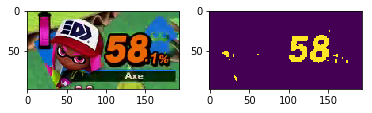

In [21]:
test_and_plot_image(test_image_path)

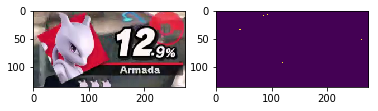

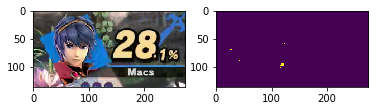

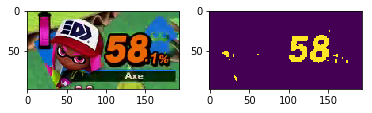

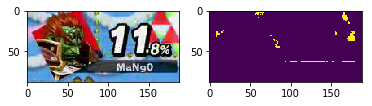

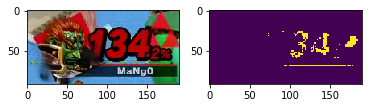

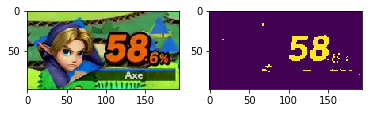

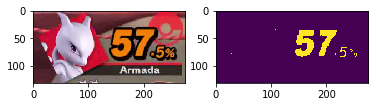

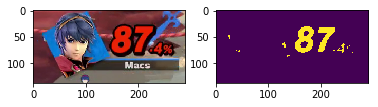

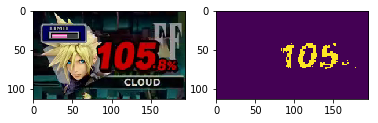

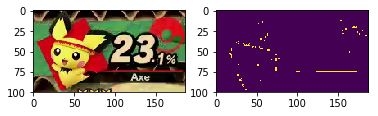

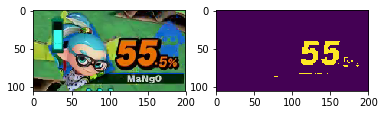

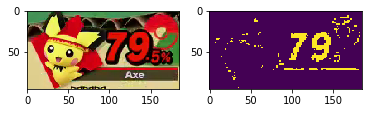

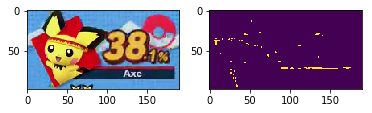

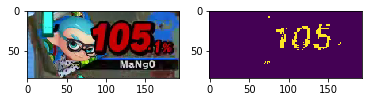

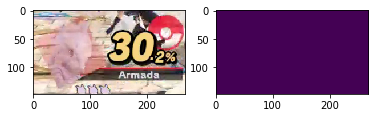

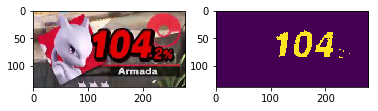

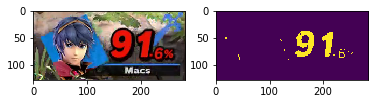

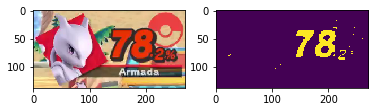

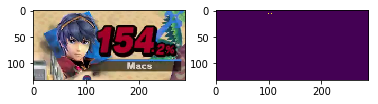

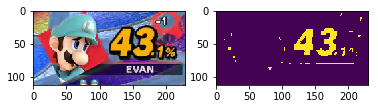

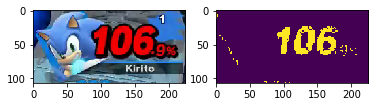

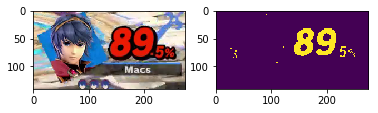

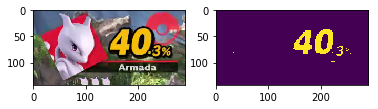

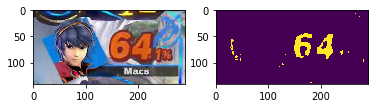

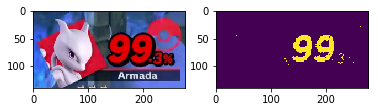

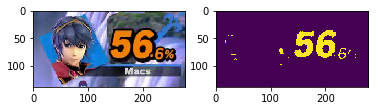

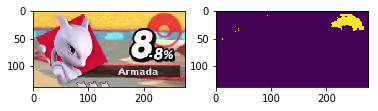

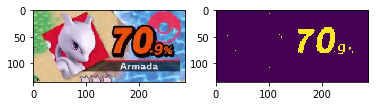

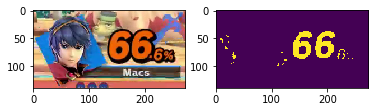

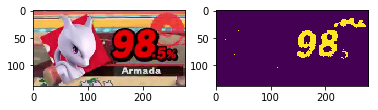

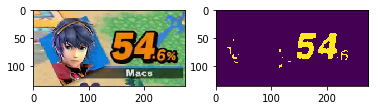

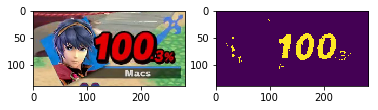

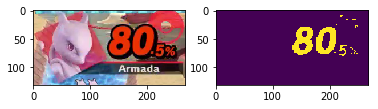

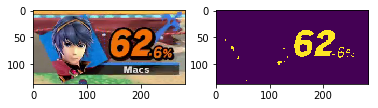

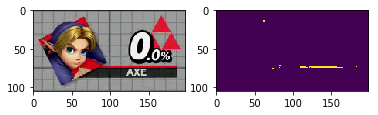

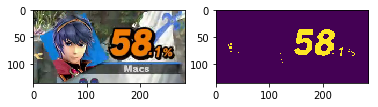

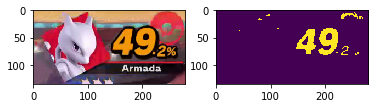

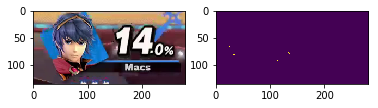

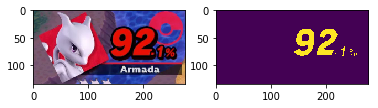

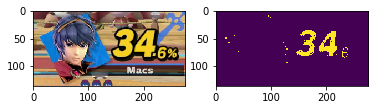

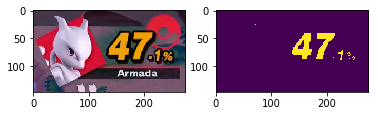

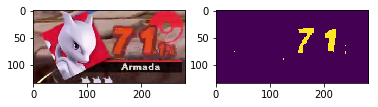

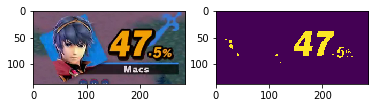

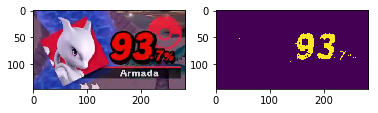

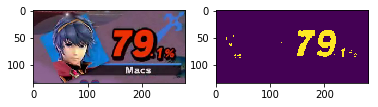

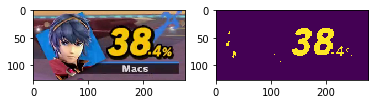

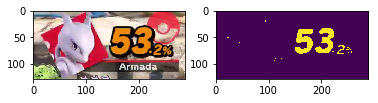

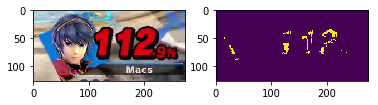

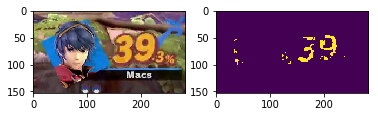

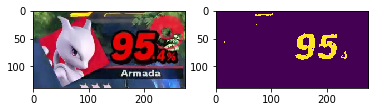

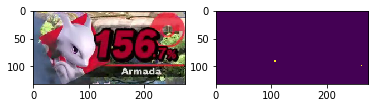

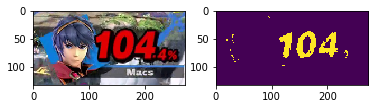

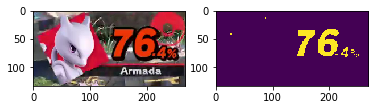

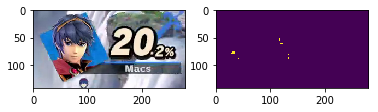

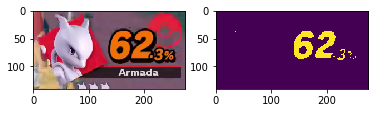

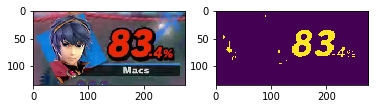

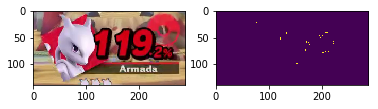

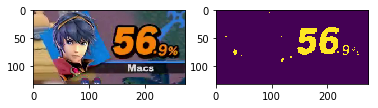

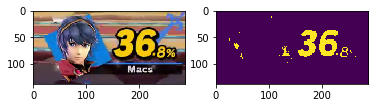

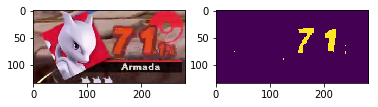

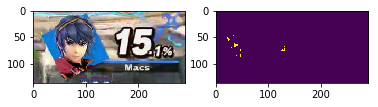

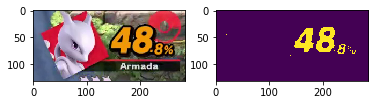

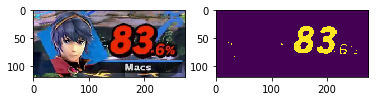

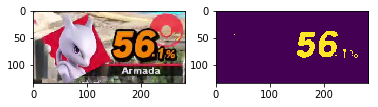

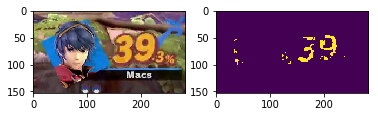

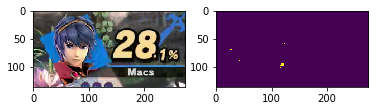

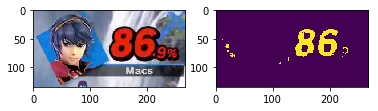

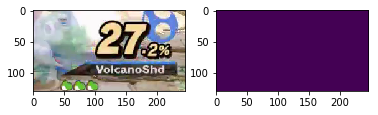

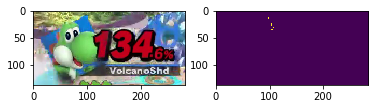

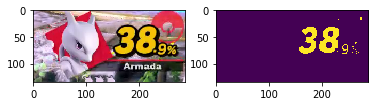

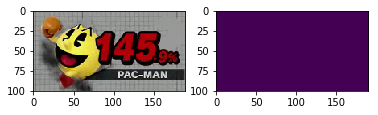

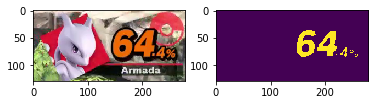

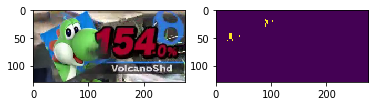

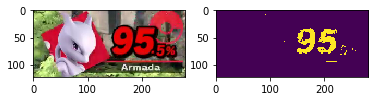

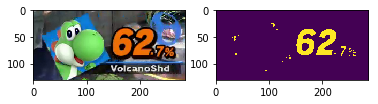

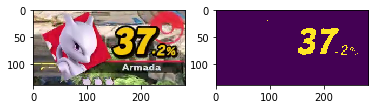

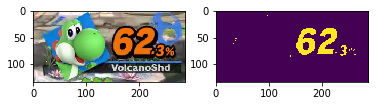

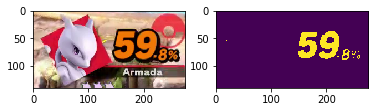

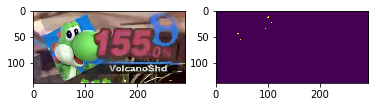

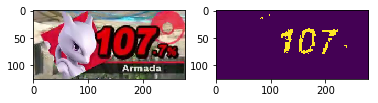

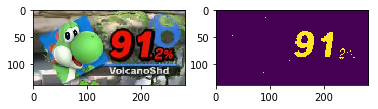

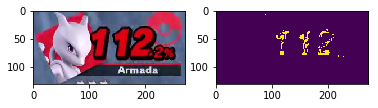

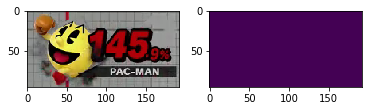

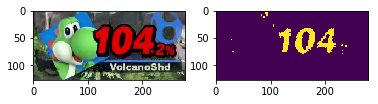

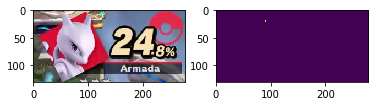

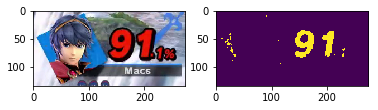

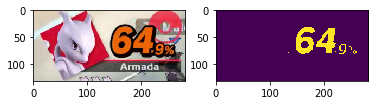

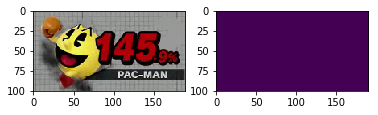

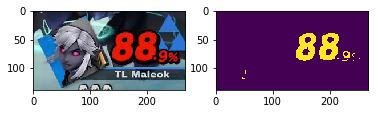

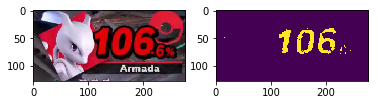

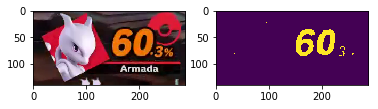

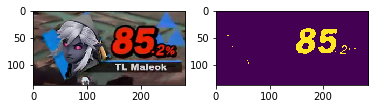

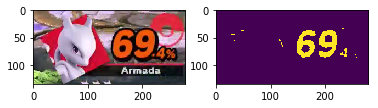

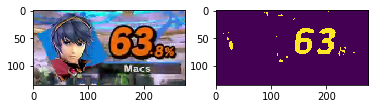

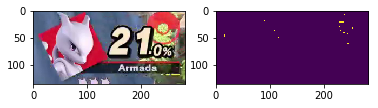

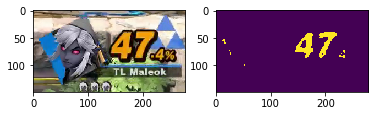

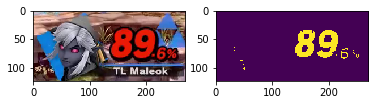

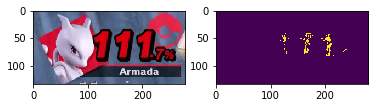

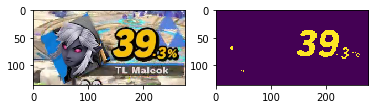

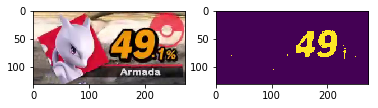

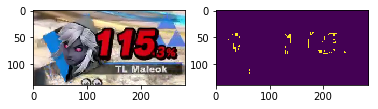

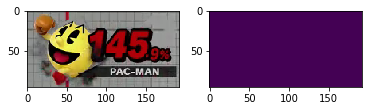

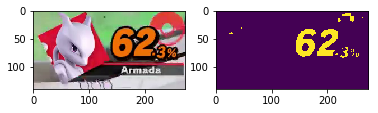

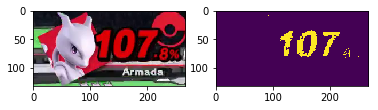

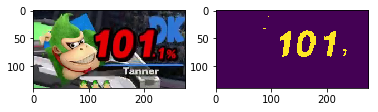

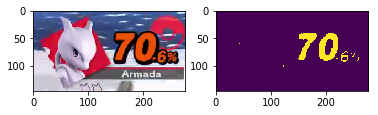

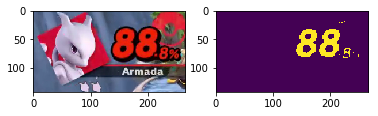

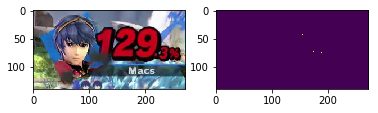

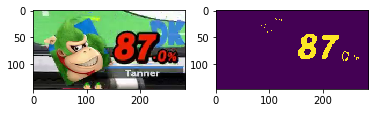

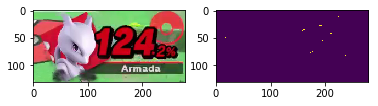

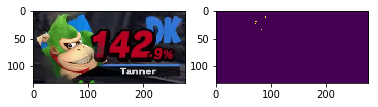

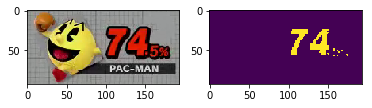

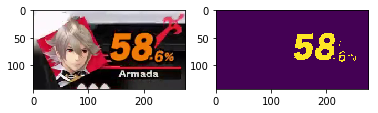

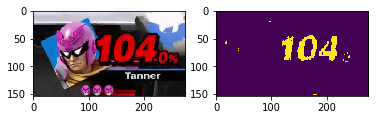

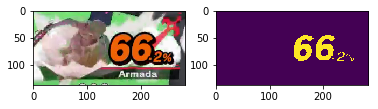

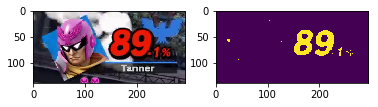

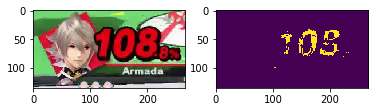

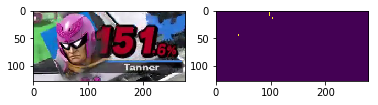

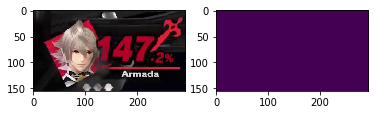

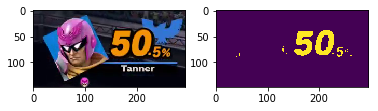

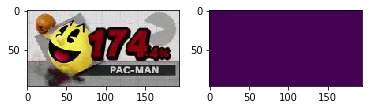

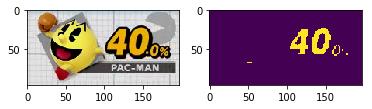

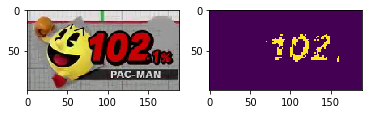

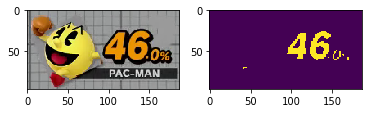

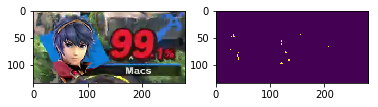

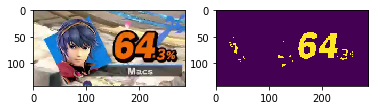

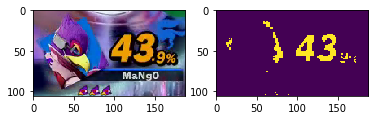

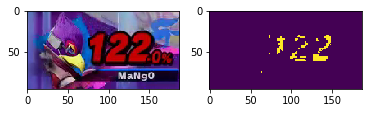

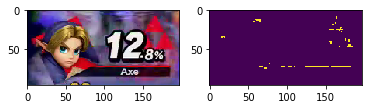

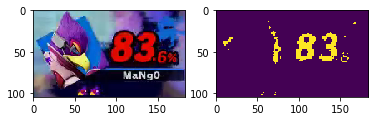

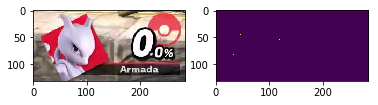

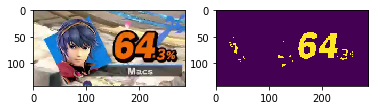

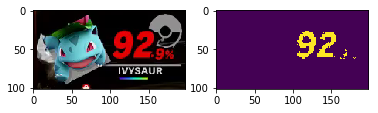

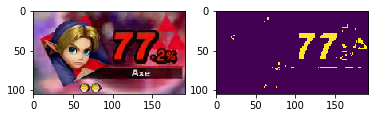

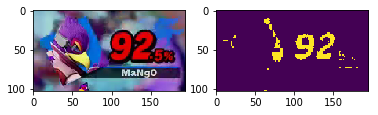

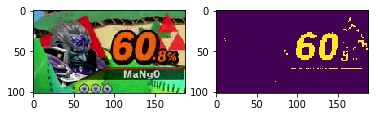

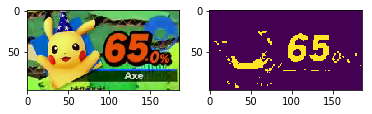

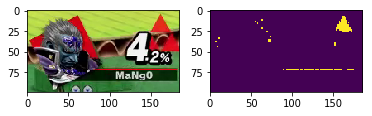

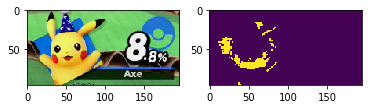

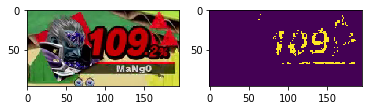

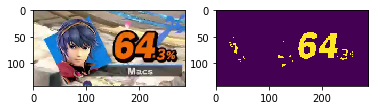

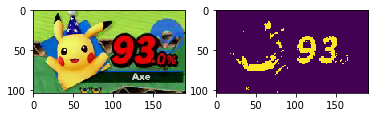

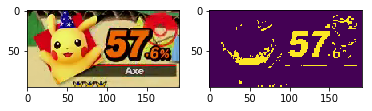

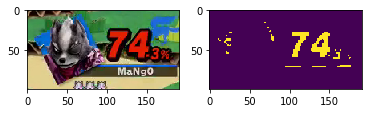

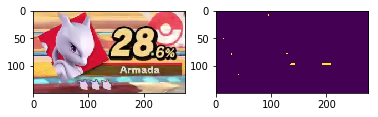

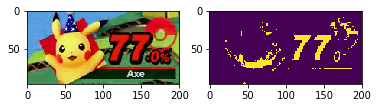

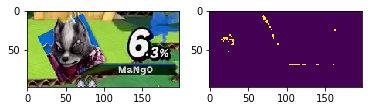

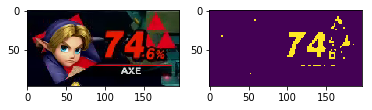

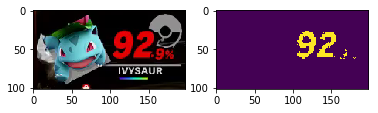

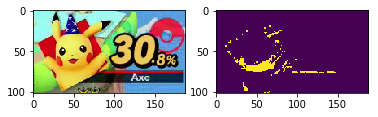

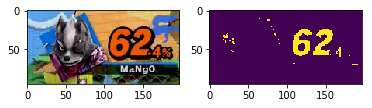

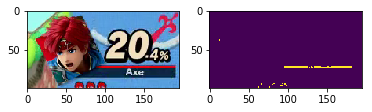

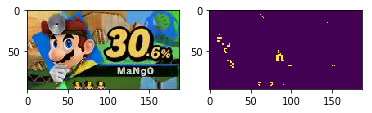

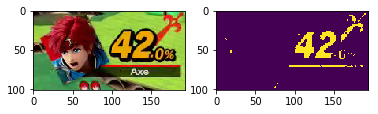

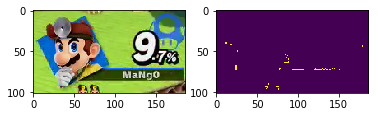

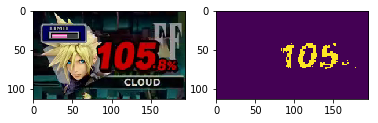

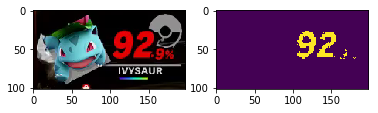

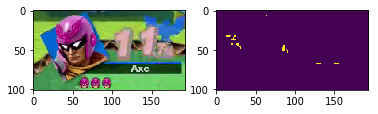

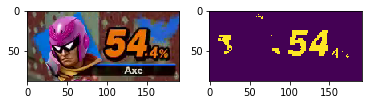

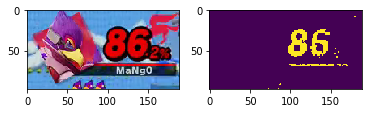

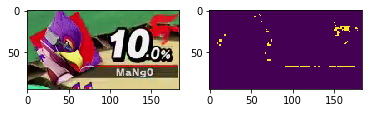

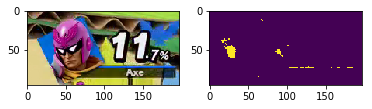

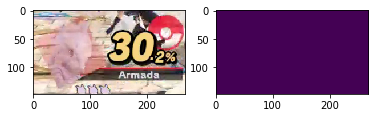

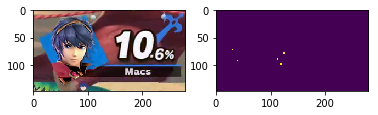

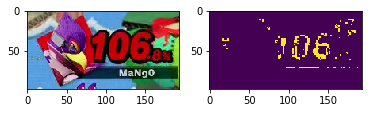

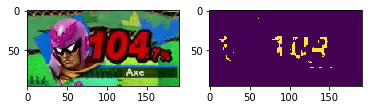

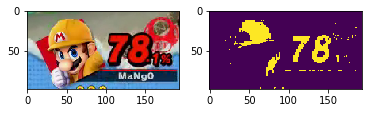

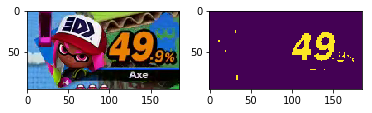

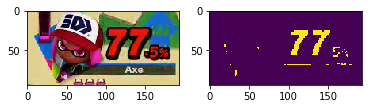

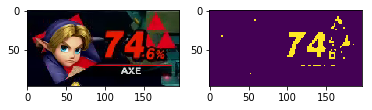

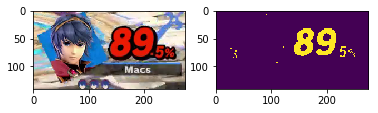

In [28]:
for imgfile in [f for f in os.listdir(image_mask_dir) if f[-4:] == ".png" and not "mask" in f]:
    imgpath = os.path.join(image_mask_dir, imgfile)
    test_and_plot_image(imgpath)
    
    #
    # Too many figures, gotta undermine matplotlib's inline plotting to save
    # ram and eliminate some really verbose and annoying warnings.
    #
    plt.show()
    plt.close('all')